# Курсовой проект

### Подключение библиотек и скриптов

In [2759]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV

# Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [2760]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [2761]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Загрузка данных

##### Описание датасета

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [2762]:
ds_train = pd.read_csv('train.csv', sep=',')

ds_train.head(15)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


In [2763]:
ds_train.shape

(10000, 20)

In [2764]:
ds_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Приведение типов данных

In [2765]:
ds_train['Id'] = ds_train['Id'].astype(str)
ds_train[['Rooms', 'HouseFloor', 'KitchenSquare']] = ds_train[['Rooms', 'HouseFloor', 'KitchenSquare']].astype(int)

ds_train = reduce_mem_usage(ds_train) # уменьшение размерности типов данных

ds_train.info()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.74 MB
Decreased by 51.6%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  int16   
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 no

## 1. EDA

### Целевая переменная (Price)

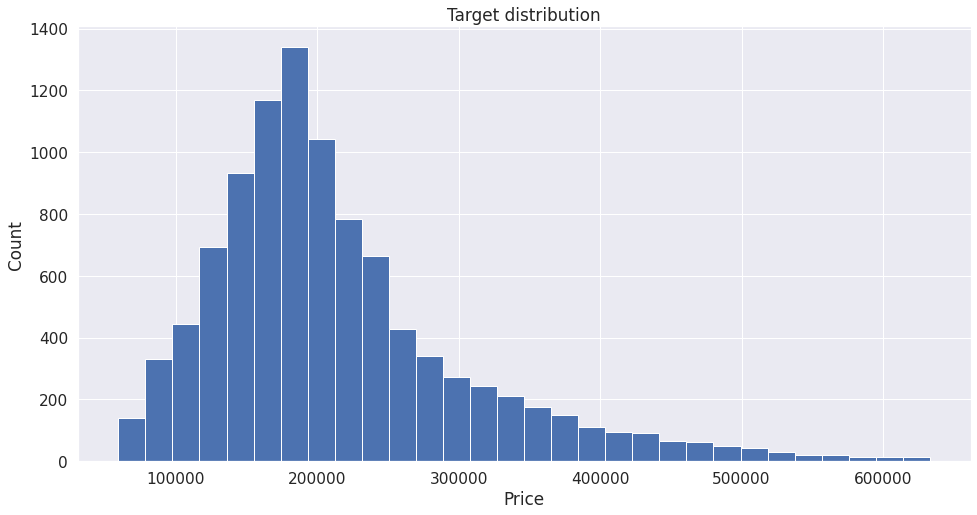

In [2766]:
plt.figure(figsize = (16,8))

ds_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Количественные переменные

In [2767]:
ds_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,43.587592,0.839512,21.058716,86.241219,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [2768]:
ds_train.nunique()

Id               10000
DistrictId         205
Rooms                9
Square            9995
LifeSquare        7886
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price             9996
dtype: int64

#### float

In [2769]:
feature_names = ds_train.select_dtypes(include=['float64', 'float32', 'float16', 'int64'])
for column in feature_names: 
    print(f'{column}\n{ds_train[column].value_counts(dropna=False)}\n\n')

Square
37.498161    2
65.285133    2
80.794792    2
44.482914    2
81.867165    2
            ..
63.952770    1
39.010426    1
66.681969    1
72.683846    1
35.815475    1
Name: Square, Length: 9995, dtype: int64


LifeSquare
NaN          2113
33.859653       2
45.835346       1
46.740765       1
13.446544       1
             ... 
36.626949       1
20.293858       1
22.134413       1
49.385098       1
22.301367       1
Name: LifeSquare, Length: 7887, dtype: int64


Ecology_1
0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.012522      1
0.014334      1
Name: Ecology_1, Length: 129, dtype: int64


Healthcare_1
NaN       4798
540.0      511
30.0       348
1046.0     245
750.0      163
          ... 
370.0       14
32.0        12
1815.0      10
35.0         2
0.0          1
Name: Healthcare_1, Length: 80, dtype: int64


Price
298194.500000    2
204576.421875    2
238608.656250    2
182938.078

#### int

In [2770]:
feature_names = ds_train.select_dtypes(include=['int64', 'int32', 'int16', 'int8'])
for column in feature_names: 
    print(f'{column}\n{ds_train[column].value_counts(dropna=False).sort_index()}\n\n')

DistrictId
0       48
1      652
2       78
3       82
4       11
      ... 
202      2
205      1
207      1
208      2
209      1
Name: DistrictId, Length: 205, dtype: int64


Rooms
0        8
1     3705
2     3880
3     2235
4      150
5       18
6        1
10       2
19       1
Name: Rooms, dtype: int64


KitchenSquare
0        697
1       2460
2          4
3         22
4         39
5       1169
6       1038
7        609
8       1306
9        843
10      1075
11       233
12       249
13        67
14        51
15        31
16        16
17        12
18         6
19        11
20        14
21         1
22         3
23         1
25         2
26         1
27         1
29         1
30         2
31         1
32         2
35         1
36         1
37         2
39         1
40         1
41         2
42         1
43         2
48         1
51         2
53         1
54         1
58         2
60         1
62         1
63         1
66         1
72         1
73         1
75         1
78         1

### Номинативные переменные

In [2771]:
feature_names = ds_train.select_dtypes(include='category').columns.tolist()
for column in feature_names:
    print(f'{column}\n{ds_train[column].value_counts()}\n\n')

Id
0        1
4927     1
4916     1
4918     1
4920     1
        ..
15035    1
15036    1
15037    1
15038    1
9999     1
Name: Id, Length: 10000, dtype: int64


Ecology_2
B    9903
A      97
Name: Ecology_2, dtype: int64


Ecology_3
B    9725
A     275
Name: Ecology_3, dtype: int64


Shops_2
B    9175
A     825
Name: Shops_2, dtype: int64




## 2. Обработка выбросов и пропусков

### Rooms

In [2772]:
ds_train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

Будем считать, что квартиры с более пятью комнатами -- выбросами. Создадим доппризнак, где отметим квартиры с 0 и более 5 комнат "1", а остальные "0"

In [2773]:
ds_train['Rooms_change'] = 0
ds_train.loc[(ds_train['Rooms'] == 0) | (ds_train['Rooms'] > 5), 'Rooms_change'] = 1

ds_train[(ds_train['Rooms_change'] == 1)].head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_change
2004,5927,57,10,59.056976,36.223072,10,22,22,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.312500,1
2194,3159,88,0,38.697117,19.345131,9,9,16,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.109375,1


Заменим значения Rooms по выбросам на медиану в зависимости от площади квартиры, умножив предварительно Square < 10 на 10 и отметив эти значения доппризнаком

In [2774]:
ds_train['Square_change'] = 0
ds_train.loc[(ds_train['Square'] < 10), 'Square_change'] = 1
ds_train.loc[(ds_train['Square'] < 10), 'Square'] = ds_train['Square'] * 10
ds_train.loc[(ds_train['Square_change'] == 1), 'Square']

161     29.543085
328     43.903309
1401    51.292213
4496    19.889427
4800    45.027840
5009    46.334984
7033    54.970612
7470    11.368588
8572    25.963512
8805    43.807259
9067    48.236794
9869    23.772476
Name: Square, dtype: float32

In [2775]:
sq_rooms = round(ds_train.loc[(ds_train['Rooms_change'] == 1), 'Square'], 0).unique()

for sq in sq_rooms:
    m_rooms = round(ds_train.loc[(ds_train["Square"].round(0) == sq), "Rooms"].median(), 0)
    ds_train.loc[(ds_train['Rooms_change'] == 1) & (ds_train['Square'].round(0) == sq), 'Rooms'] = m_rooms if m_rooms > 0 else 1
ds_train[(ds_train['Rooms_change'] == 1)].head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_change,Square_change
2004,5927,57,2,59.056976,36.223072,10,22,22,2002,0.090799,...,74,19083,2,NaN,5,15,B,317265.312500,1,0
2194,3159,88,1,38.697117,19.345131,9,9,16,1982,0.127376,...,43,8429,3,NaN,3,9,B,158998.109375,1,0


In [2776]:
ds_train['Rooms'].value_counts()

2    3885
1    3710
3    2237
4     150
5      18
Name: Rooms, dtype: int64

<AxesSubplot:xlabel='Rooms', ylabel='count'>

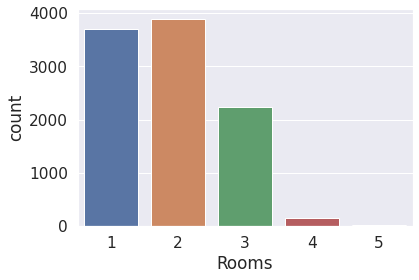

In [2777]:
sns.countplot(x='Rooms', data=ds_train)

### LifeSquare, Square, KitchenSquare

In [2778]:
ds_train[['Square', 'KitchenSquare', 'LifeSquare']].head(15)

,Square,KitchenSquare,LifeSquare
0,115.027313,10,NaN
1,39.832523,8,23.169222
2,78.342216,10,47.671970
3,40.409908,1,NaN
4,64.285065,9,38.562515
5,62.528465,6,47.103832
6,33.938751,9,21.772930
7,50.391815,8,32.893257
8,46.887894,1,44.628132
9,79.867477,1,75.085129


#### KitchenSquare

In [2779]:
ds_train[['KitchenSquare']].value_counts().sort_index()

KitchenSquare
0                 697
1                2460
2                   4
3                  22
4                  39
5                1169
6                1038
7                 609
8                1306
9                 843
10               1075
11                233
12                249
13                 67
14                 51
15                 31
16                 16
17                 12
18                  6
19                 11
20                 14
21                  1
22                  3
23                  1
25                  2
26                  1
27                  1
29                  1
30                  2
31                  1
32                  2
35                  1
36                  1
37                  2
39                  1
40                  1
41                  2
42                  1
43                  2
48                  1
51                  2
53                  1
54                  1
58                  2
60                

In [2780]:
ds_train['KitchenSquare'].quantile(0.975), ds_train['KitchenSquare'].quantile(0.025)

(13.0, 0.0)

Будем считать, что кухни менее 3 м кв. -- выбросы. Сделаем доп признак, где отметим строки с площадью кухни менее 3 и более 13 м кв. (по квантилю) -- "1", а остальные -- "0".

In [2781]:
ds_train['KitchenSquare_change'] = 0
ds_train.loc[(~ds_train['KitchenSquare'].between(3,13)) | (ds_train['KitchenSquare'].isna()), 'KitchenSquare_change'] = 1

ds_train[(ds_train['KitchenSquare_change'] == 1)].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_change,Square_change,KitchenSquare_change
3,2352,1,1,40.409908,NaN,1,10,22,1977,0.007122,...,264,0,NaN,0,1,B,168106.000000,0,0,1
8,9951,1,1,46.887894,44.628132,1,12,20,1977,0.007122,...,264,0,NaN,0,1,B,160400.406250,0,0,1
9,8094,6,3,79.867477,75.085129,1,3,17,2014,0.243205,...,1564,0,540.0,0,0,B,194756.031250,0,0,1
18,4581,1,1,47.582481,NaN,1,16,16,1977,0.007122,...,264,0,NaN,0,1,B,128803.593750,0,0,1
19,367,45,1,42.367290,40.012527,1,16,14,2015,0.195781,...,5212,6,NaN,3,2,B,250466.984375,0,0,1


Заменим значения KitchenSquare по выбросам на медиану в зависимости от количества комнат в квартире

In [2782]:
for i in range(1,6):
    ds_train.loc[(ds_train['KitchenSquare_change'] == 1) & (ds_train['Rooms'] == i), 'KitchenSquare'] = \
        round(ds_train.loc[(ds_train['KitchenSquare_change'] == 0) & (ds_train['Rooms'] == i), 'KitchenSquare'].median(), 0)
    
ds_train['KitchenSquare'].value_counts().sort_index()

3       22
4       39
5     1169
6     1038
7     1883
8     3341
9      884
10    1075
11     233
12     249
13      67
Name: KitchenSquare, dtype: int64

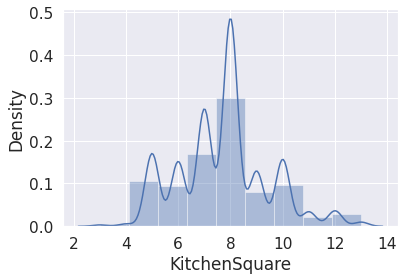

In [2783]:
sns.distplot(ds_train['KitchenSquare'], bins=9);

#### Square

In [2784]:
ds_train['Square'].quantile(0.025), ds_train['Square'].quantile(0.975)

(32.17308349609375, 100.90624904632566)

Отметим в доппризнаке Square_change квартиры со значениями выходящими за квантили и со значениями NaN

In [2785]:
ds_train.loc[~ds_train['Square'].between(ds_train['Square'].quantile(0.025), ds_train['Square'].quantile(0.975)) | ds_train['Square'].isna(), 'Square_change'] = 1
ds_train.loc[(ds_train['Square_change'] == 1), ['Square', 'Rooms', 'Square_change']].head(15)

,Square,Rooms,Square_change
0,115.027313,3,1
32,104.769020,4,1
63,30.961868,1,1
92,31.828480,1,1
108,31.691656,1,1
111,28.438793,1,1
116,105.479256,3,1
123,102.522270,4,1
130,29.706032,1,1
136,119.914993,4,1


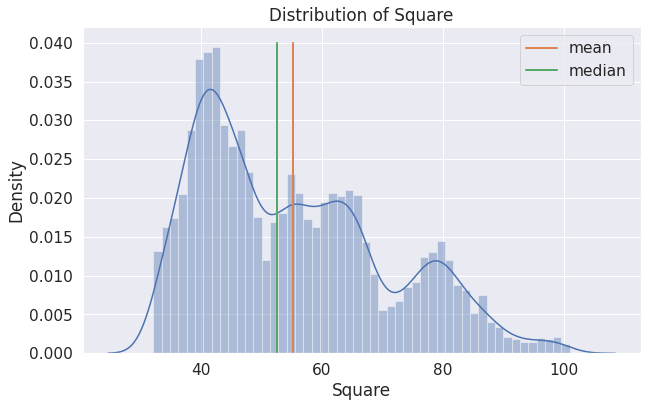

In [2786]:
df = ds_train.loc[(ds_train['Square_change'] == 0), 'Square']
target_mean = df.mean()
target_median = df.median()

plt.figure(figsize = (10,6))

sns.distplot(df, bins=50)

y = np.linspace(0, 0.04, 2)
plt.plot([target_mean] * 2 , y, label='mean', linewidth=2)
plt.plot([target_median] * 2, y, label='median', linewidth=2)

plt.title('Distribution of Square')
plt.legend()
plt.show()

Заменим выбросы по Square на медиану в зависимости от количества комнат в квартире

In [2787]:
for count_rooms in range(1,6):
    ds_train.loc[(ds_train['Square_change'] == 1) & (ds_train['Rooms'] == count_rooms), 'Square'] = ds_train.loc[(ds_train['Square_change'] == 0) & (ds_train['Rooms'] == count_rooms), 'Square'].median()

ds_train.loc[(ds_train['Square_change'] == 1), ['Square', 'KitchenSquare', 'LifeSquare', 'Rooms']]

,Square,KitchenSquare,LifeSquare,Rooms
0,76.768845,10,NaN,3
32,89.457092,8,79.316650,4
63,40.758541,6,15.168644,1
92,40.758541,5,15.222566,1
108,40.758541,5,20.108517,1
...,...,...,...,...
9915,40.758541,7,12.125029,1
9937,89.457092,9,94.268669,4
9971,76.768845,12,63.452793,3
9990,40.758541,8,11.419796,1


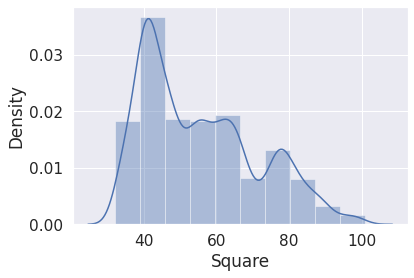

In [2788]:
sns.distplot(ds_train['Square'], bins=10);

#### LifeSquare

In [2789]:
ds_train['LifeSquare'].describe()

count    7887.000000
mean       37.199665
std        86.241219
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

In [2790]:
ds_train['LifeSquare'].quantile(0.025), ds_train['LifeSquare'].quantile(0.975)

(5.9141297, 80.7481)

In [2791]:
ds_train.loc[(ds_train['LifeSquare'] > ds_train['Square']), 'Square'].count()

508

Сделаем доппризнак, где отметим "1" все выбросы по LifeSquare

In [2792]:
ds_train['LifeSquare_change'] = 0

ds_train.loc[ds_train['LifeSquare'].isna() | (ds_train['Square'] < ds_train['LifeSquare']) | ~ds_train['LifeSquare'].between(ds_train['LifeSquare'].quantile(0.025), ds_train['LifeSquare'].quantile(0.975)), 'LifeSquare_change'] = 1

ds_train.loc[(ds_train['LifeSquare_change'] == 1), ['Square', 'KitchenSquare', 'LifeSquare', 'LifeSquare_change']]

,Square,KitchenSquare,LifeSquare,LifeSquare_change
0,76.768845,10,NaN,1
3,40.409908,8,NaN,1
18,47.582481,8,NaN,1
20,50.974892,8,NaN,1
24,44.203945,8,NaN,1
...,...,...,...,...
9982,36.112392,8,1.855415,1
9983,63.324024,7,NaN,1
9987,62.690056,10,64.602936,1
9991,62.648777,7,NaN,1


Высчитаем медиану допплощади квартиры (коридоры, ванна и пр.) в зависимости от количества комнат и таким образом вычислим медиану LifeSquare для каждой из групп в зависимости от количества комнат

In [2793]:
for count_rooms in range(1,6):
    df = ds_train.loc[(ds_train['LifeSquare_change'] == 0) & (ds_train['Rooms'] == count_rooms), ['LifeSquare', 'Square', 'KitchenSquare']]
    dop_square = df['Square'].median() - df['KitchenSquare'].median() - df['LifeSquare'].median()
    ds_train.loc[(ds_train['LifeSquare_change'] == 1) & (ds_train['Rooms'] == count_rooms), 'LifeSquare'] = ds_train.loc[(ds_train['LifeSquare_change'] == 1) & (ds_train['Rooms'] == count_rooms), 'Square'] - ds_train.loc[(ds_train['LifeSquare_change'] == 1) & (ds_train['Rooms'] == count_rooms), 'KitchenSquare'] - dop_square
    
ds_train[['Square', 'KitchenSquare', 'LifeSquare', 'Rooms']].describe()

,Square,KitchenSquare,LifeSquare,Rooms
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,55.420174,7.73320,35.324467,1.888100
std,15.847678,1.73093,13.477994,0.811446
min,32.173229,3.00000,5.927865,1.000000
25%,41.739367,7.00000,23.236159,1.000000
50%,52.415850,8.00000,32.920763,2.000000
75%,65.801809,9.00000,45.033619,2.000000
max,100.904266,13.00000,80.577263,5.000000


### HouseFloor, Floor

In [2794]:
ds_train.loc[(ds_train['HouseFloor'] == 1), ['HouseFloor', 'Floor']].describe()

,HouseFloor,Floor
count,497.0,497.000000
mean,1.0,9.384306
std,0.0,5.963193
min,1.0,1.000000
25%,1.0,4.000000
50%,1.0,8.000000
75%,1.0,13.000000
max,1.0,28.000000


In [2795]:
ds_train['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117], dtype=int8)

In [2796]:
ds_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [2797]:
(ds_train['Floor'] > ds_train['HouseFloor']).sum()

1825

В Floor значения адекватные.

В HouseFloor есть выбросы: 0, 99 и 117 этажей.

А также есть строки, где этаж квартиры больше этажности самого дома.

Определим доппризнак, где отметим выбросы по HouseFloor, заменим HouseFloor = 0, NaN и более 51 этажей на медиану, а значения Floor больше HouseFloor на рандомное целое число меньшее HouseFloor.

In [2798]:
ds_train['HouseFloor_change'] = 0
ds_train.loc[(ds_train['HouseFloor'] < ds_train['Floor']) | (~ds_train['HouseFloor'].between(1,51)), 'HouseFloor_change'] = 1

ds_train.loc[~ds_train['HouseFloor'].between(1,51), 'HouseFloor'] = round(ds_train.loc[ds_train['HouseFloor'].between(1,51), 'HouseFloor'].median(), 0)

ind_hf = ds_train.loc[(ds_train['HouseFloor'] < ds_train['Floor']), 'Floor'].index
ds_train.loc[ind_hf, 'Floor'] = ds_train.loc[ind_hf, 'HouseFloor'].apply(lambda x: random.randint(1, x))

ds_train[(ds_train['HouseFloor_change'] == 1)].head(15)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_change,Square_change,KitchenSquare_change,LifeSquare_change,HouseFloor_change
17,1190,8,2,49.396000,28.299601,5,3,5,1962,0.458174,...,1130.0,1,5,B,186971.921875,0,0,0,0,1
19,367,45,1,42.367290,40.012527,8,12,14,2015,0.195781,...,NaN,3,2,B,250466.984375,0,0,1,0,1
21,8471,20,3,75.611061,47.494621,8,1,9,1976,0.019509,...,176.0,5,5,B,366916.250000,0,0,0,0,1
24,4717,27,1,44.203945,25.409922,8,2,14,1977,0.072158,...,NaN,0,0,A,135466.562500,0,0,1,1,1
25,4521,6,2,65.409966,44.860733,7,1,1,1977,0.243205,...,540.0,0,0,B,191205.265625,0,0,1,1,1
26,8553,88,3,83.262527,55.201206,8,1,1,1977,0.127376,...,NaN,3,9,B,410883.906250,0,0,1,1,1
33,847,74,2,73.314972,52.765739,7,2,6,1977,0.075779,...,NaN,0,2,B,254005.375000,0,0,1,1,1
34,7757,27,2,58.783661,55.441257,11,4,12,1977,0.011654,...,NaN,0,0,B,138396.984375,0,0,0,0,1
37,1699,9,1,78.936165,76.746651,8,5,7,1977,0.161532,...,30.0,2,4,B,226206.968750,0,0,1,0,1
39,3736,167,2,56.712772,36.454063,7,2,5,1956,0.050272,...,1020.0,0,3,B,299177.500000,0,0,0,0,1


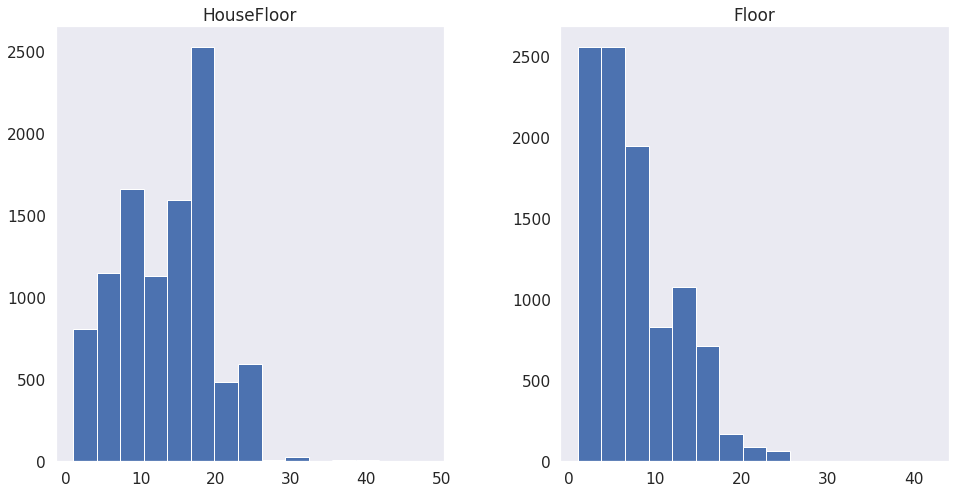

In [2799]:
ds_train[['HouseFloor', 'Floor']].hist(figsize=(16,8), bins=15, grid=False);

### HouseYear

In [2800]:
ds_train['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

Здесь просто заменим года из будущего на текущий год

In [2801]:
ds_train.loc[(ds_train['HouseYear'] > 2022), 'HouseYear'] = 2022
ds_train['HouseYear'].describe()

count    10000.000000
mean      1984.872800
std         18.417132
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2022.000000
Name: HouseYear, dtype: float64

### Healthcare_1

In [2802]:
ds_train['Healthcare_1'].isna().sum(), ds_train.loc[(ds_train['Healthcare_1'] == 0), 'Healthcare_1'].count()

(4798, 1)

In [2803]:
ds_train['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.519470
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [2804]:
ds_train['Healthcare_1'].unique()

array([  nan, 1183.,  240., 2078.,   80.,  176.,  540., 2620.,   30.,
       1937., 1130.,  705., 1970.,  520.,  770., 1020., 1322., 1340.,
       1940., 2300.,  320., 2301., 3300., 4702., 2857.,  145., 2643.,
       1406.,  350.,  628., 1548.,  125., 1430., 2672.,  900., 1145.,
       1046.,  620., 4087.,   75., 1015.,  830.,  229.,  165., 1036.,
        990., 1084.,  750.,  645.,  562., 2729.,  100.,   32.,  800.,
        810., 1450., 4129.,  920.,  730., 2715., 1308.,   46., 4508.,
       1894., 1575.,  262.,  192., 1547., 1994., 2890., 2500.,  370.,
        325., 4849.,   35., 1815., 3855., 1786.,  200.,    0.],
      dtype=float32)

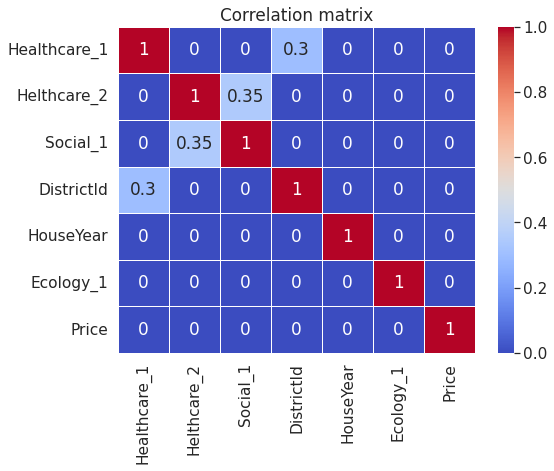

In [2805]:
df = ds_train.loc[~ds_train['Healthcare_1'].isna(),\
                  ['Healthcare_1', 'Helthcare_2', 'Social_1', 'DistrictId', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Price']]

plt.figure(figsize = (8,6))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Видно, что практически половина данных по Healthcare_1 отсутствуют или равны 0 (чего не может быть, т.к. по уникальным значениям можно предположить, что это какие-то закодированные показатели (т.к. уникальных мало), например, количество машин скорой помощи. И не может быть такого в наше время в Московской области, чтобы не было ни одной машины в каком-либо районе).

Также видно, что 'Healthcare_1' коррелирует с номером района.

Поэтому:

1. Добавим доппризнак
2. Заменим пропуски и нулевые значения на медиану в зависимости от района
3. Если невозможно вычислить медиану по какому-либо району, заменим на общую медиану

In [2806]:
ds_train['Healthcare_1_change'] = 0
ds_train.loc[ds_train['Healthcare_1'].isna() | (ds_train['Healthcare_1'] == 0), 'Healthcare_1_change'] = 1

for item in ds_train['DistrictId'].unique():
    h1_mode = ds_train.loc[(ds_train['Healthcare_1_change'] == 0) & (ds_train['DistrictId'] == item), 'Healthcare_1'].mode()
    if len(h1_mode) > 0:
        ds_train.loc[(ds_train['Healthcare_1_change'] == 1) & (ds_train['DistrictId'] == item), 'Healthcare_1'] = h1_mode[0]
        
ds_train.loc[(ds_train['Healthcare_1'] == 0) | ds_train['Healthcare_1'].isna(), 'Healthcare_1'] = ds_train.loc[(ds_train['Healthcare_1_change'] == 0), 'Healthcare_1'].mode()[0]

ds_train[['Healthcare_1']].describe()

,Healthcare_1
count,10000.000000
mean,979.189392
std,911.734192
min,30.000000
25%,540.000000
50%,540.000000
75%,1322.000000
max,4849.000000


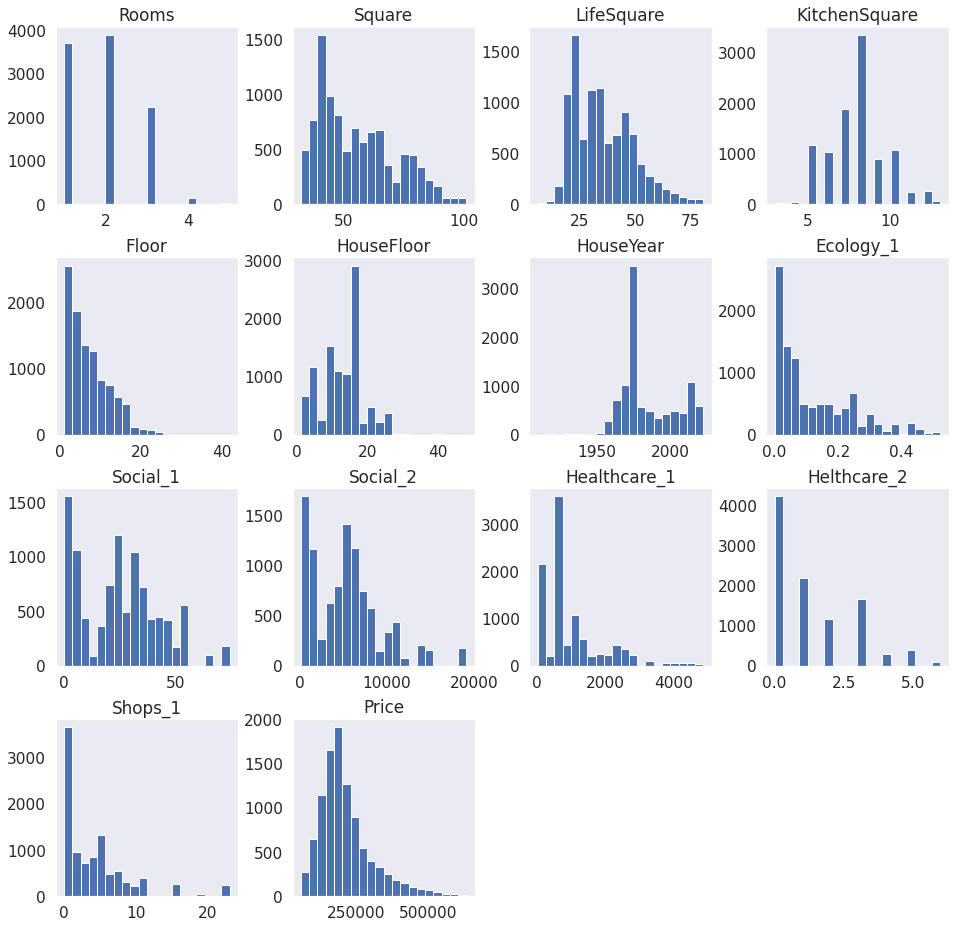

In [2807]:
df = ds_train[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
               'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Healthcare_1', 'Helthcare_2', 
               'Shops_1', 'Price']]

df.hist(figsize=(16,16), bins=20, grid=False);

## 4. Построение новых признаков

### Ecology_2, Ecology_3, Shops_2 to binary

In [2808]:
ds_train[['Ecology_2', 'Ecology_3', 'Shops_2']].head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [2809]:
ds_train['Ecology_2'].value_counts(), ds_train['Ecology_3'].value_counts(), ds_train['Shops_2'].value_counts()

(B    9903
 A      97
 Name: Ecology_2, dtype: int64,
 B    9725
 A     275
 Name: Ecology_3, dtype: int64,
 B    9175
 A     825
 Name: Shops_2, dtype: int64)

Заменим на бинарные значения по Ecology_2, Ecology_3 и Shops_2

In [2810]:
cat_to_int = {'A': 0, 'B': 1}

ds_train['Ecology_2'] = ds_train['Ecology_2'].replace(cat_to_int)
ds_train['Ecology_3'] = ds_train['Ecology_3'].replace(cat_to_int)
ds_train['Shops_2'] = ds_train['Shops_2'].replace(cat_to_int)

ds_train['Ecology_2'].value_counts(), ds_train['Ecology_3'].value_counts(), ds_train['Shops_2'].value_counts()

(1    9903
 0      97
 Name: Ecology_2, dtype: int64,
 1    9725
 0     275
 Name: Ecology_3, dtype: int64,
 1    9175
 0     825
 Name: Shops_2, dtype: int64)

In [2811]:
ds_train[['Ecology_2', 'Ecology_3', 'Shops_2']] = ds_train[['Ecology_2', 'Ecology_3', 'Shops_2']].astype(np.int8)
ds_train[['Ecology_2', 'Ecology_3', 'Shops_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Ecology_2  10000 non-null  int8 
 1   Ecology_3  10000 non-null  int8 
 2   Shops_2    10000 non-null  int8 
dtypes: int8(3)
memory usage: 29.4 KB


### DistrictId in DistrictSize

In [2812]:
district_size = ds_train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
ds_train = ds_train.merge(district_size, on='DistrictId', how='left')
ds_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_change,Square_change,KitchenSquare_change,LifeSquare_change,HouseFloor_change,Healthcare_1_change,DistrictSize
0,11809,27,3,76.768845,46.707523,10,4,10,2014,0.075424,...,0,1,305018.875000,0,1,0,1,0,1,851
1,3013,22,1,39.832523,23.169222,8,7,8,1966,0.118537,...,0,1,177734.546875,0,0,0,0,0,0,78
2,8215,1,3,78.342216,47.671970,10,2,17,1988,0.025609,...,1,1,282078.718750,0,0,0,0,0,0,652
3,2352,1,1,40.409908,21.615885,8,10,22,1977,0.007122,...,1,1,168106.000000,0,0,1,1,0,1,652
4,13866,94,2,64.285065,38.562515,9,16,16,1972,0.282798,...,6,1,343995.093750,0,0,0,0,0,1,89


### Floor

Проведем классификацию квартир в зависимости от этажа и количества комнат:

1. 1--2 и последний

2. 3--7

3. 8--15

4. 16 и выше, кроме последнего

Сначала сделаем вспомогательный признак Floor_cat

In [2813]:
ds_train['Floor_cat'] = 0
ds_train.loc[(ds_train['Floor'] == ds_train['HouseFloor']) | (ds_train['Floor'] < 3), 'Floor_cat'] = 1
ds_train.loc[ds_train['Floor'].between(3,7) & (ds_train['Floor_cat'] == 0), 'Floor_cat'] = 2
ds_train.loc[ds_train['Floor'].between(8,15) & (ds_train['Floor_cat'] == 0), 'Floor_cat'] = 3
ds_train.loc[(ds_train['Floor'] > 15) & (ds_train['Floor_cat'] == 0), 'Floor_cat'] = 4
ds_train[['Floor', 'HouseFloor', 'Floor_cat']]

,Floor,HouseFloor,Floor_cat
0,4,10,2
1,7,8,2
2,2,17,1
3,10,22,3
4,16,16,1
...,...,...,...
9995,3,12,2
9996,13,14,3
9997,3,5,2
9998,3,9,2


Далее сделаем доппризнак, сгруппировав по Floor_cat' и 'Rooms и вычислив медиану Price по этим группам

In [2814]:
MedPriceByFloorcatRooms = ds_train.groupby(['Floor_cat', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorcatRooms'})
ds_train = ds_train.merge(MedPriceByFloorcatRooms, on=['Floor_cat', 'Rooms'], how='left')
ds_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_change,Square_change,KitchenSquare_change,LifeSquare_change,HouseFloor_change,Healthcare_1_change,DistrictSize,Floor_cat,MedPriceByFloorcatRooms
0,11809,27,3,76.768845,46.707523,10,4,10,2014,0.075424,...,305018.875000,0,1,0,1,0,1,851,2,268378.125000
1,3013,22,1,39.832523,23.169222,8,7,8,1966,0.118537,...,177734.546875,0,0,0,0,0,0,78,2,156073.875000
2,8215,1,3,78.342216,47.671970,10,2,17,1988,0.025609,...,282078.718750,0,0,0,0,0,0,652,1,244852.015625
3,2352,1,1,40.409908,21.615885,8,10,22,1977,0.007122,...,168106.000000,0,0,1,1,0,1,652,3,156382.296875
4,13866,94,2,64.285065,38.562515,9,16,16,1972,0.282798,...,343995.093750,0,0,0,0,0,1,89,1,190962.531250


Также сделаем доппризнак, сгруппировав по Floor_cat и Square и вычислив медиану Price по этим группам.

Но если мы возьмем площадь квартиры как она записана, то получится много групп, что может привести к переобучению модели. Поэтому можно округлить площадь до десятков и записать эти значения в доппризнак

In [2815]:
ds_train['Square_r'] = ds_train['Square'].astype(np.int8)
ds_train['Square_r'] = round(ds_train['Square_r'] / 10) * 10

ds_train[['Square_r', 'Square']].head()

,Square_r,Square
0,80.0,76.768845
1,40.0,39.832523
2,80.0,78.342216
3,40.0,40.409908
4,60.0,64.285065


In [2816]:
ds_train['Square_r'].unique()

array([ 80.,  40.,  60.,  30.,  50.,  70.,  90., 100.])

In [2817]:
MedPriceByFloorcatSquarer = ds_train.groupby(['Floor_cat', 'Square_r'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorcatSquarer'})
ds_train = ds_train.merge(MedPriceByFloorcatSquarer, on=['Floor_cat', 'Square_r'], how='left')
ds_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Square_change,KitchenSquare_change,LifeSquare_change,HouseFloor_change,Healthcare_1_change,DistrictSize,Floor_cat,MedPriceByFloorcatRooms,Square_r,MedPriceByFloorcatSquarer
0,11809,27,3,76.768845,46.707523,10,4,10,2014,0.075424,...,1,0,1,0,1,851,2,268378.125000,80.0,311125.50000
1,3013,22,1,39.832523,23.169222,8,7,8,1966,0.118537,...,0,0,0,0,0,78,2,156073.875000,40.0,168568.03125
2,8215,1,3,78.342216,47.671970,10,2,17,1988,0.025609,...,0,0,0,0,0,652,1,244852.015625,80.0,278777.75000
3,2352,1,1,40.409908,21.615885,8,10,22,1977,0.007122,...,0,1,1,0,1,652,3,156382.296875,40.0,161912.12500
4,13866,94,2,64.285065,38.562515,9,16,16,1972,0.282798,...,0,0,0,0,1,89,1,190962.531250,60.0,211662.28125


### HouseFloor

Обычно жилые дома в России классифицируются по этажности:

малоэтажные (1--2 этажа);
средней этажности (3--5 этажей);
многоэтажные (6 и более этажей);
повышенной этажности (11--16 этажей);
высотные (более 16 этажей)

In [2818]:
ds_train['HouseFloor_cat'] = 0
ds_train.loc[(ds_train['HouseFloor'] < 3), 'HouseFloor_cat'] = 1
ds_train.loc[ds_train['HouseFloor'].between(3,5), 'HouseFloor_cat'] = 2
ds_train.loc[ds_train['HouseFloor'].between(6,10), 'HouseFloor_cat'] = 3
ds_train.loc[ds_train['HouseFloor'].between(11,16), 'HouseFloor_cat'] = 4
ds_train.loc[(ds_train['HouseFloor'] > 16), 'HouseFloor_cat'] = 5
ds_train[['HouseFloor', 'HouseFloor_cat']]

,HouseFloor,HouseFloor_cat
0,10,3
1,8,3
2,17,5
3,22,5
4,16,4
...,...,...
9995,12,4
9996,14,4
9997,5,2
9998,9,3


Сделаем два доппризнака сгруппировав (HouseFloor_cat, Rooms) и (HouseFloor_cat, Square_r) и вычислив медиану Price

In [2819]:
MedPriceByHouseFloorcatRooms = ds_train.groupby(['HouseFloor_cat', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByHouseFloorcatRooms'})
ds_train = ds_train.merge(MedPriceByHouseFloorcatRooms, on=['HouseFloor_cat', 'Rooms'], how='left')

ds_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_change,HouseFloor_change,Healthcare_1_change,DistrictSize,Floor_cat,MedPriceByFloorcatRooms,Square_r,MedPriceByFloorcatSquarer,HouseFloor_cat,MedPriceByHouseFloorcatRooms
0,11809,27,3,76.768845,46.707523,10,4,10,2014,0.075424,...,1,0,1,851,2,268378.125000,80.0,311125.50000,3,254389.140625
1,3013,22,1,39.832523,23.169222,8,7,8,1966,0.118537,...,0,0,0,78,2,156073.875000,40.0,168568.03125,3,158375.468750
2,8215,1,3,78.342216,47.671970,10,2,17,1988,0.025609,...,0,0,0,652,1,244852.015625,80.0,278777.75000,5,273141.000000
3,2352,1,1,40.409908,21.615885,8,10,22,1977,0.007122,...,1,0,1,652,3,156382.296875,40.0,161912.12500,5,142849.406250
4,13866,94,2,64.285065,38.562515,9,16,16,1972,0.282798,...,0,0,1,89,1,190962.531250,60.0,211662.28125,4,216436.109375


In [2820]:
MedPriceByHouseFloorcatSquarer = ds_train.groupby(['HouseFloor_cat', 'Square_r'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByHouseFloorcatSquarer'})
ds_train = ds_train.merge(MedPriceByHouseFloorcatSquarer, on=['HouseFloor_cat', 'Square_r'], how='left')

ds_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_change,Healthcare_1_change,DistrictSize,Floor_cat,MedPriceByFloorcatRooms,Square_r,MedPriceByFloorcatSquarer,HouseFloor_cat,MedPriceByHouseFloorcatRooms,MedPriceByHouseFloorcatSquarer
0,11809,27,3,76.768845,46.707523,10,4,10,2014,0.075424,...,0,1,851,2,268378.125000,80.0,311125.50000,3,254389.140625,357031.781250
1,3013,22,1,39.832523,23.169222,8,7,8,1966,0.118537,...,0,0,78,2,156073.875000,40.0,168568.03125,3,158375.468750,176590.281250
2,8215,1,3,78.342216,47.671970,10,2,17,1988,0.025609,...,0,0,652,1,244852.015625,80.0,278777.75000,5,273141.000000,269421.281250
3,2352,1,1,40.409908,21.615885,8,10,22,1977,0.007122,...,0,1,652,3,156382.296875,40.0,161912.12500,5,142849.406250,138964.546875
4,13866,94,2,64.285065,38.562515,9,16,16,1972,0.282798,...,0,1,89,1,190962.531250,60.0,211662.28125,4,216436.109375,238629.453125


### HouseYear

Купеческие дома -- 1900-1920-х годах. Этажность - от 1 до 2, реже 3 этажа, большие комнаты

«Сталинка» – 1950--1963 г. (1947--1953), кухни 7-9 метров, большие жилые площади

«Улучшенка» – 1970--1990-х г. (1980--1998), имеют неплохие, даже по современным меркам, планировки и площади квартир, кухни от 7 м в 1 к.кв. до 9,5 м в 3-4 к.кв.

Типовые или стандартные квартиры – 1970--1980-х г. 

«Хрущевки» – квартиры в пятиэтажках 1957--1973 г.(1960--1978), имеют маленькую кухню

«Малогабаритки» – это маленькие компактные квартиры, построенные в разное время и имеющие, как правило, одну комнату.

In [2821]:
ds_train['HouseYear'].min()

1910

Сделаем категории по годам застройки:
1. до 1920
2. 1921--1945
3. 1946--1960
4. 1961--1980
5. 1981--2000
6. 2001--2010
7. после 2011

In [2822]:
ds_train['HouseYear_cat'] = 0
ds_train.loc[(ds_train['HouseYear'] < 1920), 'HouseYear_cat'] = 1
ds_train.loc[(ds_train['HouseYear'].between(1921, 1945)), 'HouseYear_cat'] = 2
ds_train.loc[(ds_train['HouseYear'].between(1946, 1960)), 'HouseYear_cat'] = 3
ds_train.loc[(ds_train['HouseYear'].between(1961, 1980)), 'HouseYear_cat'] = 4
ds_train.loc[(ds_train['HouseYear'].between(1981, 2000)), 'HouseYear_cat'] = 5
ds_train.loc[(ds_train['HouseYear'].between(2001, 2010)), 'HouseYear_cat'] = 6
ds_train.loc[(ds_train['HouseYear'] > 2010), 'HouseYear_cat'] = 7
ds_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1_change,DistrictSize,Floor_cat,MedPriceByFloorcatRooms,Square_r,MedPriceByFloorcatSquarer,HouseFloor_cat,MedPriceByHouseFloorcatRooms,MedPriceByHouseFloorcatSquarer,HouseYear_cat
0,11809,27,3,76.768845,46.707523,10,4,10,2014,0.075424,...,1,851,2,268378.125000,80.0,311125.500000,3,254389.140625,357031.781250,7
1,3013,22,1,39.832523,23.169222,8,7,8,1966,0.118537,...,0,78,2,156073.875000,40.0,168568.031250,3,158375.468750,176590.281250,4
2,8215,1,3,78.342216,47.671970,10,2,17,1988,0.025609,...,0,652,1,244852.015625,80.0,278777.750000,5,273141.000000,269421.281250,5
3,2352,1,1,40.409908,21.615885,8,10,22,1977,0.007122,...,1,652,3,156382.296875,40.0,161912.125000,5,142849.406250,138964.546875,4
4,13866,94,2,64.285065,38.562515,9,16,16,1972,0.282798,...,1,89,1,190962.531250,60.0,211662.281250,4,216436.109375,238629.453125,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2,49.090729,33.272625,6,3,12,1981,0.300323,...,1,118,2,200696.703125,50.0,198183.078125,4,216436.109375,209225.718750,5
9996,16265,27,2,64.307686,37.038422,9,13,14,1977,0.072158,...,1,851,3,209399.218750,60.0,217211.218750,4,216436.109375,238629.453125,4
9997,2795,178,1,40.758541,16.555363,5,3,5,1958,0.460556,...,1,7,2,156073.875000,40.0,168568.031250,2,148828.859375,168255.937500,3
9998,14561,21,1,32.330292,22.326870,5,3,9,1969,0.194489,...,0,165,2,156073.875000,30.0,156040.343750,3,158375.468750,160119.203125,4


Сгруппируем по HouseYear_cat, Square_r и вычислим медиану Price, записав значения в доппризнак

In [2823]:
MedPriceByHouseYearcatSquarer = ds_train.groupby(['HouseYear_cat', 'Square_r'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByHouseYearcatSquarer'})
ds_train = ds_train.merge(MedPriceByHouseYearcatSquarer, on=['HouseYear_cat', 'Square_r'], how='left')

ds_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictSize,Floor_cat,MedPriceByFloorcatRooms,Square_r,MedPriceByFloorcatSquarer,HouseFloor_cat,MedPriceByHouseFloorcatRooms,MedPriceByHouseFloorcatSquarer,HouseYear_cat,MedPriceByHouseYearcatSquarer
0,11809,27,3,76.768845,46.707523,10,4,10,2014,0.075424,...,851,2,268378.125000,80.0,311125.50000,3,254389.140625,357031.781250,7,242243.093750
1,3013,22,1,39.832523,23.169222,8,7,8,1966,0.118537,...,78,2,156073.875000,40.0,168568.03125,3,158375.468750,176590.281250,4,160513.421875
2,8215,1,3,78.342216,47.671970,10,2,17,1988,0.025609,...,652,1,244852.015625,80.0,278777.75000,5,273141.000000,269421.281250,5,335529.000000
3,2352,1,1,40.409908,21.615885,8,10,22,1977,0.007122,...,652,3,156382.296875,40.0,161912.12500,5,142849.406250,138964.546875,4,160513.421875
4,13866,94,2,64.285065,38.562515,9,16,16,1972,0.282798,...,89,1,190962.531250,60.0,211662.28125,4,216436.109375,238629.453125,4,201553.250000


### Социальные показатели

In [2824]:
ds_train.iloc[:,9:-14]

,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_change,Square_change
0,0.075424,1,1,11,3097,0,540.0,0,0,1,305018.875000,0,1
1,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.546875,0,0
2,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.718750,0,0
3,0.007122,1,1,1,264,0,240.0,0,1,1,168106.000000,0,0
4,0.282798,1,1,33,8667,2,540.0,0,6,1,343995.093750,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.300323,1,1,52,10311,6,80.0,1,9,1,119367.453125,0,0
9996,0.072158,1,1,2,629,1,540.0,0,0,0,199715.156250,0,0
9997,0.460556,1,1,20,4386,14,628.0,1,5,1,165953.906250,0,1
9998,0.194489,1,1,47,8004,3,125.0,3,5,1,171842.406250,0,0


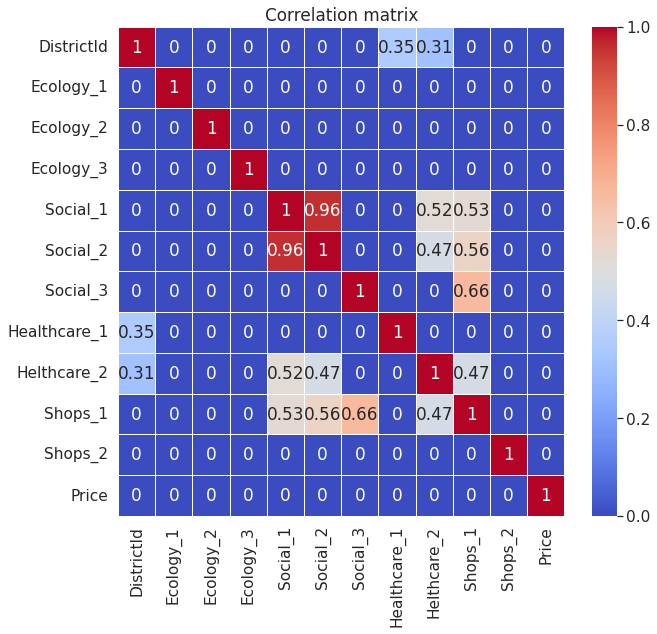

In [2825]:
df = ds_train[['DistrictId', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2',\
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price']]

plt.figure(figsize = (10,9))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [2826]:
MedPriceBySocial = ds_train.groupby(['Social_3', 'Helthcare_2', 'Shops_1'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceBySocial'})
ds_train = ds_train.merge(MedPriceBySocial, on=['Social_3', 'Helthcare_2', 'Shops_1'], how='left')

ds_train.iloc[:5, -5:]

,MedPriceByHouseFloorcatRooms,MedPriceByHouseFloorcatSquarer,HouseYear_cat,MedPriceByHouseYearcatSquarer,MedPriceBySocial
0,254389.140625,357031.781250,7,242243.093750,142140.15625
1,158375.468750,176590.281250,4,160513.421875,186809.59375
2,273141.000000,269421.281250,5,335529.000000,205993.37500
3,142849.406250,138964.546875,4,160513.421875,167850.62500
4,216436.109375,238629.453125,4,201553.250000,203153.53125


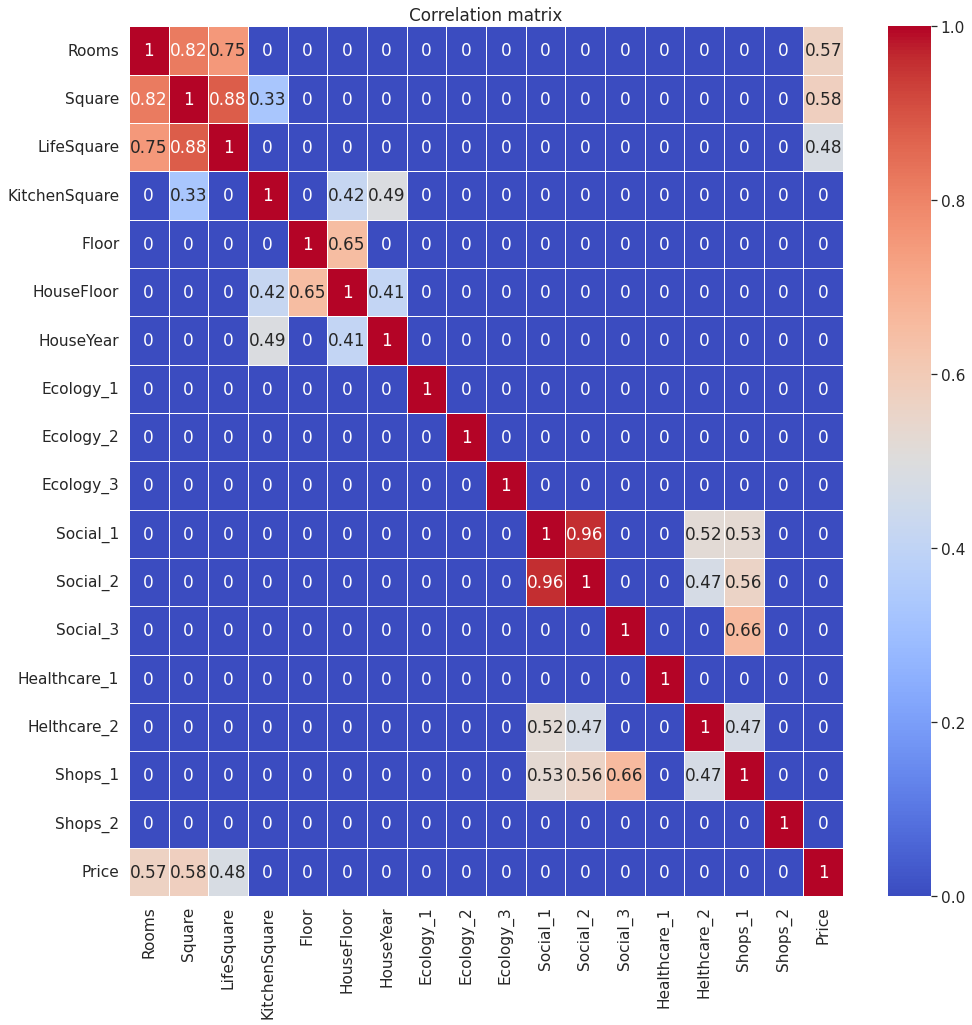

In [2827]:
df = ds_train[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
               'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
               'Helthcare_2', 'Shops_1', 'Shops_2', 'Price']]

plt.figure(figsize = (16,16))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Проверим показатели датафрейма

In [2828]:
ds_train.isna().sum().sum()

0

In [2829]:
ds_train.shape

(10000, 37)

## 5. Определение классов

In [2830]:
class DataPreprocessing:
    
    # Подготовка исходных данных
    
    def __init__(self):  # параметры класса
        self.medians_rooms = {}
        self.medians_kitchen_square = {}
        self.medians_square = {}
        self.medians_dop_square = {}
        self.median_house_floor = None
        self.quantile_kitchen_square = None        
        self.quantiles_square = []
        self.quantiles_life_square = []
        self.limit_house_floor = [1, 51]
        self.mode_healthcare_1 = {}

        
    def fit(self, X):  # сохранение статистик
        # quantiles to Square
        self.quantiles_square.insert(0, X['Square'].quantile(0.025))
        self.quantiles_square.insert(1, X['Square'].quantile(0.975))
        
        # quantile(0.975) to KitchenSquare
        self.quantile_kitchen_square = X['KitchenSquare'].quantile(0.975)
        
        # quantiles to LifeSquare
        self.quantiles_life_square.insert(0, X['LifeSquare'].quantile(0.025))
        self.quantiles_life_square.insert(1, X['LifeSquare'].quantile(0.975))
        
        # medians to Rooms (в зависимости от Square)
        list_square = round(X.loc[X['Square'].between(self.quantiles_square[0], self.quantiles_square[1]), 'Square'], 0).unique().tolist()
        for item in list_square:
            m_rooms = round(X.loc[(X['Square'].round(0) == item), 'Rooms'].median(), 0)
            if m_rooms > 0:
                self.medians_rooms[item] = m_rooms
        self.medians_rooms[0] = round(X['Rooms'].median(), 0) # если квартира площадью, которой нет в обучающем датафрейме

        # medians в зависимости от количества комнат в квартире
        condition = (~X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna() & (X['Square'] > X['LifeSquare']))
        for i in range(1,6):
            if i in X['Rooms'].unique():
                # KitchenSquare
                self.medians_kitchen_square[i] = round(X.loc[X['KitchenSquare'].between(3, self.quantile_kitchen_square) & (X['Rooms'] == i), 'KitchenSquare'].median(), 0)
                
                # Square
                self.medians_square[i] = X.loc[X['Square'].between(self.quantiles_square[0], self.quantiles_square[1]) & (X['Rooms'] == i), 'Square'].median()

                # LifeSquare
                self.medians_dop_square[i] = \
                    X.loc[condition & (X['Rooms'] == i), 'Square'].median() - \
                    X.loc[condition & (X['Rooms'] == i), 'KitchenSquare'].median() - \
                    X.loc[condition & (X['Rooms'] == i), 'LifeSquare'].median()
            
        # medians to HouseFloor
        self.median_house_floor = round(X.loc[X['HouseFloor'].between(self.limit_house_floor[0], self.limit_house_floor[1]), 'HouseFloor'].median(), 0)

        # mode to Healthcare_1
        for item in X.loc[(~X['Healthcare_1'].isna()) | (X['Healthcare_1'] > 0), 'DistrictId'].unique():
            h1_mode = X.loc[((~X['Healthcare_1'].isna()) | (X['Healthcare_1'] > 0)) & (X['DistrictId'] == item), 'Healthcare_1'].mode()
            if len(h1_mode) > 0:
                self.mode_healthcare_1[item] = h1_mode[0]
        self.mode_healthcare_1['middle'] = X.loc[(~X['Healthcare_1'].isna()) | (X['Healthcare_1'] > 0), 'Healthcare_1'].mode()[0]
        
        
    def transform(self, X):  # трансформация данных    
        # Rooms
        X['Square_change'] = 0
        X.loc[(X['Square'] < 10), 'Square_change'] = 1
        X.loc[(X['Square'] < 10), 'Square'] = X['Square'] * 10
        X['Rooms_change'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 5), 'Rooms_change'] = 1
        list_square = X.loc[(X['Rooms_change'] == 1), 'Square'].round(0).unique().tolist()
        for item in list_square:
            if item in self.medians_rooms.keys():
                X.loc[(X['Rooms_change'] == 1) & (X['Square'].round(0) == item), 'Rooms'] = self.medians_rooms[item]
            else:
                X.loc[(X['Rooms_change'] == 1) & (X['Square'].round(0) == item), 'Rooms'] = self.medians_rooms[0]
        
        # KitchenSquare
        X['KitchenSquare_change'] = 0
        X.loc[~X['KitchenSquare'].between(3, self.quantile_kitchen_square), 'KitchenSquare_change'] = 1
        for i in range(1,6):
            X.loc[(X['KitchenSquare_change'] == 1) & (X['Rooms'] == i), 'KitchenSquare'] = self.medians_kitchen_square[i]
                    
        #Square
        X.loc[~X['Square'].between(self.quantiles_square[0], self.quantiles_square[1]), 'Square_change'] = 1
        for i in range(1,6):
            X.loc[(X['Square_change'] == 1) & (X['Rooms'] == i), 'Square'] = self.medians_square[i]

        # LifeSquare
        X['LifeSquare_change'] = 0
        X.loc[(X['Square'] < X['LifeSquare']) | (~X['LifeSquare'].between(self.quantiles_life_square[0], self.quantiles_life_square[1])), 'LifeSquare_change'] = 1
        for i in range(1,6):
            X.loc[(X['LifeSquare_change'] == 1) & (X['Rooms'] == i), 'LifeSquare'] = X.loc[(X['LifeSquare_change'] == 1) & (X['Rooms'] == i), 'Square'] - X.loc[(X['LifeSquare_change'] == 1) & (X['Rooms'] == i), 'KitchenSquare'] - self.medians_dop_square[i]
 
        # HouseFloor
        X['HouseFloor_change'] = 0
        X.loc[(X['HouseFloor'] < X['Floor']) | (~X['HouseFloor'].between(self.limit_house_floor[0], self.limit_house_floor[1])), 'HouseFloor_change'] = 1
        # заменяем выбросы по этажности дома
        X.loc[~X['HouseFloor'].between(self.limit_house_floor[0], self.limit_house_floor[1]), 'HouseFloor'] = self.median_house_floor
        # заменяем если этаж квартиры больше этажности дома
        index_floor = X.loc[(X['HouseFloor'] < X['Floor']), 'Floor'].index
        X.loc[index_floor, 'Floor'] = X.loc[index_floor, 'HouseFloor'].apply(lambda x: random.randint(1, x))

        # HouseYear
        current_year = datetime.now().year
        X['HouseYear_change'] = 0
        X.loc[(X['HouseYear'] > current_year), 'HouseYear_change'] = 1
        X.loc[(X['HouseYear'] > current_year), 'HouseYear'] = current_year
        
        # Healthcare_1
        X['Healthcare_1_change'] = 0
        X.loc[X['Healthcare_1'].isna() | X['Healthcare_1'] == 0, 'Healthcare_1_change'] = 1
        for item in X['DistrictId'].unique():
            if item in self.mode_healthcare_1.keys():
                X.loc[(X['Healthcare_1_change'] == 1) & (X['DistrictId'] == item), 'Healthcare_1'] = self.mode_healthcare_1[item]
        X.loc[(X['Healthcare_1'].isna()), 'Healthcare_1'] = self.mode_healthcare_1['middle']

        return X

In [2831]:
class FeatureGenerator():
    
    # Генерация новых фич
    
    def __init__(self):
        self.cat_to_int = {'A': 0, 'B': 1}
        self.district_size = None
        self.MedPriceByFloorcatRooms = None
        self.MedPriceByFloorcatSquarer = None
        self.MedPriceByHouseFloorcatRooms = None
        self.MedPriceByHouseFloorcatSquarer = None
        self.MedPriceByHouseYearcatRooms = None
        self.MedPriceByHouseYearcatSquarer = None
        self.MedPriceBySocial = None
        self.floor_cat = {1: [0, 3],
                          2: [3, 7],
                          3: [8, 15]
                         }
        self.house_floor_cat = {1: [1, 2],
                                2: [3, 5],
                                3: [6, 10],
                                4: [11, 16]
                               }
        self.house_year_cat = {1: [0, 1920],
                               2: [1921, 1945],
                               3: [1946, 1960],
                               4: [1961, 1980],
                               5: [1981, 2000],
                               6: [2001, 2010],
                               7: [2011, datetime.now().year]
                              }
        
        
    def fit(self, X, y=None):
        df = X.copy()  # чтобы не испортить Х при присоединении 'Price' для рассчетов
        
        # Binary features ('Ecology_2', 'Ecology_3', 'Shops_2')
        df = self.binary_features(df)

        # DistrictId to DistrictSize
        self.district_size = df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # Floor to Floor_cat
        df = self.floor_category(df)
        
        # HouseFloor to HouseFloor_cat
        df = self.house_floor_category(df)
            
        # HouseYear to HouseYear_cat
        df = self.house_year_category(df)
        
        # Square to Square_round
        df = self.square_round(df)

        if y is not None:
            df['Price'] = y.values
            
            # Floor_cat & Rooms & Price.median
            self.MedPriceByFloorcatRooms = df.groupby(['Floor_cat', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorcatRooms'})
            
            # Floor_cat & Square_round & Price.median
            self.MedPriceByFloorcatSquarer = df.groupby(['Floor_cat', 'Square_r'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorcatSquarer'})
            
            # HouseFloor_cat & Rooms & Price.median
            self.MedPriceByHouseFloorcatRooms = df.groupby(['HouseFloor_cat', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByHouseFloorcatRooms'})
            
            # HouseFloor_cat & Square_round & Price.median
            self.MedPriceByHouseFloorcatSquarer = df.groupby(['HouseFloor_cat', 'Square_r'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByHouseFloorcatSquarer'})
            
            # HouseYear_cat & Rooms & Price.median
            self.MedPriceByHouseYearcatRooms = df.groupby(['HouseYear_cat', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByHouseYearcatRooms'})
            
            # HouseYear_cat & Square_round & Price.median
            self.MedPriceByHouseYearcatSquarer = df.groupby(['HouseYear_cat', 'Square_r'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByHouseYearcatSquarer'})

            # Social_3 & Helthcare_2 & Shops_1 & Price.median
            self.MedPriceBySocial = df.groupby(['Social_3', 'Helthcare_2', 'Shops_1'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceBySocial'})

        
    def transform(self, X):
        # Binary features ('Ecology_2', 'Ecology_3', 'Shops_2')
        X = self.binary_features(X)
        
        # Floor to Floor_cat
        X = self.floor_category(X)
        
        # HouseFloor to HouseFloor_cat
        X = self.house_floor_category(X)
        
        # HouseYear to HouseYear_cat
        X = self.house_year_category(X)
        
        # Square to Square_round
        X = self.square_round(X)

        # DistrictId in DistrictSize
        X = X.merge(self.district_size, on='DistrictId', how='left')
        # если новые районы в тестовом
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        X['DistrictSize'].fillna(5, inplace=True)
        
        # Floor_cat & Rooms & Price.median
        X = X.merge(self.MedPriceByFloorcatRooms, on=['Floor_cat', 'Rooms'], how='left')
        
        # Floor_cat & Square_round & Price.median
        X = X.merge(self.MedPriceByFloorcatSquarer, on=['Floor_cat', 'Square_r'], how='left')
        X['MedPriceByFloorcatSquarer'].fillna(3, inplace=True)
        
        # HouseFloor_cat & Rooms & Price.median
        X = X.merge(self.MedPriceByHouseFloorcatRooms, on=['HouseFloor_cat', 'Rooms'], how='left')
        
        # HouseFloor_cat & Square_round & Price.median
        X = X.merge(self.MedPriceByHouseFloorcatSquarer, on=['HouseFloor_cat', 'Square_r'], how='left')
        X['MedPriceByHouseFloorcatSquarer'].fillna(10, inplace=True)
        
        # HouseYear_cat & Rooms & Price.median
        X = X.merge(self.MedPriceByHouseYearcatRooms, on=['HouseYear_cat', 'Rooms'], how='left')
        X['MedPriceByHouseYearcatRooms'].fillna(50, inplace=True)
        
        # Social_3 & Helthcare_2 & Shops_1 & Price.median
        X = X.merge(self.MedPriceBySocial, on=['Social_3', 'Helthcare_2', 'Shops_1'], how='left')
        
        # Square_round & Price.median
        X = X.merge(self.MedPriceByHouseYearcatSquarer, on=['HouseYear_cat', 'Square_r'], how='left')
        X['MedPriceByHouseYearcatSquarer'].fillna(100, inplace=True)

        return X


    # Binary features
    def binary_features(self, X):
        X['Ecology_2'] = X['Ecology_2'].replace(self.cat_to_int)
        X['Ecology_3'] = X['Ecology_3'].replace(self.cat_to_int)
        X['Shops_2'] = X['Shops_2'].replace(self.cat_to_int)
        X[['Ecology_2', 'Ecology_3', 'Shops_2']] = X[['Ecology_2', 'Ecology_3', 'Shops_2']].astype(np.int8)
        
        return X

    
    # Floor category
    def floor_category(self, X):
        X['Floor_cat'] = 0
        X.loc[(X['Floor'] == X['HouseFloor']), 'Floor_cat'] = 1  # определяем категорию для квартир на последних этажах
        for i in self.floor_cat:
            X.loc[X['Floor'].between(self.floor_cat[i][0], self.floor_cat[i][1]) & (X['Floor_cat'] == 0), 'Floor_cat'] = i
        X.loc[(X['Floor'] > self.floor_cat[i][1]) & (X['Floor_cat'] == 0), 'Floor_cat'] = (i + 1)
            
        return X
    
    
    # HouseFloor category
    def house_floor_category(self, X):
        X['HouseFloor_cat'] = 0
        for i in self.house_floor_cat:
            X.loc[X['HouseFloor'].between(self.house_floor_cat[i][0], self.house_floor_cat[i][1]), 'HouseFloor_cat'] = i
        X.loc[(X['HouseFloor'] > self.house_floor_cat[i][1]), 'HouseFloor_cat'] = (i + 1)

        return X
    
    
    # HouseYear category
    def house_year_category(self, X):
        X['HouseYear_cat'] = 0
        for i in self.house_year_cat:
            X.loc[(X['HouseYear'].between(self.house_year_cat[i][0], self.house_year_cat[i][1])), 'HouseYear_cat'] = i

        return X
    
    
    # Square to Square_r
    def square_round(self, X):
        X['Square_r'] = X['Square'].astype(np.int8)
        X['Square_r'] = round(X['Square_r'] / 10) * 10
        
        return X


## 6. Отбор признаков

In [2832]:
ds_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_change',
 'Square_change',
 'KitchenSquare_change',
 'LifeSquare_change',
 'HouseFloor_change',
 'Healthcare_1_change',
 'DistrictSize',
 'Floor_cat',
 'MedPriceByFloorcatRooms',
 'Square_r',
 'MedPriceByFloorcatSquarer',
 'HouseFloor_cat',
 'MedPriceByHouseFloorcatRooms',
 'MedPriceByHouseFloorcatSquarer',
 'HouseYear_cat',
 'MedPriceByHouseYearcatSquarer',
 'MedPriceBySocial']

In [2833]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',\
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',\
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_change', 'Square_change', 'KitchenSquare_change', 'LifeSquare_change',\
                     'HouseFloor_change', 'DistrictSize', 'Floor_cat', 'MedPriceByFloorcatRooms',\
                     'MedPriceByFloorcatSquarer', 'MedPriceByHouseFloorcatRooms',\
                     'MedPriceByHouseFloorcatSquarer', 'MedPriceByHouseYearcatSquarer', 'MedPriceBySocial']

target_name = 'Price'

## 7. Разбиение на train и test

In [2834]:
df_train = pd.read_csv('train.csv', sep=',')
df_test = pd.read_csv('test.csv', sep=',')

X = df_train.drop(columns=target_name)
y = df_train[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 26), (3300, 26), (5000, 26))

In [2835]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [2836]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 39), (3300, 39), (5000, 39))

In [2837]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [2838]:
X_train.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1',
       'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Shops_2', 'Rooms_change', 'Square_change', 'KitchenSquare_change',
       'LifeSquare_change', 'HouseFloor_change', 'DistrictSize', 'Floor_cat',
       'MedPriceByFloorcatRooms', 'MedPriceByFloorcatSquarer',
       'MedPriceByHouseFloorcatRooms', 'MedPriceByHouseFloorcatSquarer',
       'MedPriceByHouseYearcatSquarer', 'MedPriceBySocial'],
      dtype='object')

## 8. Построение модели

### LGBMRegressor

Train R2:	0.868
Test R2:	0.748


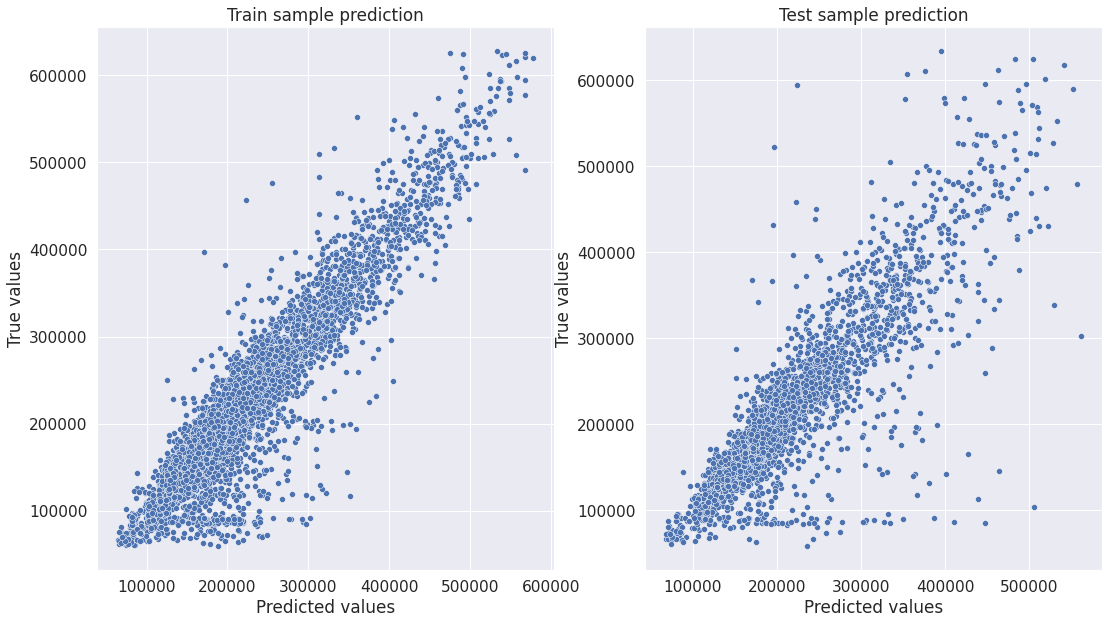

In [2839]:
from lightgbm import LGBMRegressor

l_m = LGBMRegressor(n_estimators=100,  # кол-во деревьев
                    num_leaves=30, # кол-во наблюдений в листе дерева
                    max_depth=10)  # глубина дерева
l_m.fit(X_train, y_train)

y_train_preds = l_m.predict(X_train)
y_valid_preds = l_m.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [2840]:
feature_importances = pd.DataFrame(zip(X_train.columns, l_m.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
6,HouseYear,256
22,DistrictSize,252
1,Square,250
29,MedPriceBySocial,221
2,LifeSquare,189
28,MedPriceByHouseYearcatSquarer,185
7,Ecology_1,171
5,HouseFloor,158
10,Social_1,151
12,Social_3,120


In [2841]:
cv_score = cross_val_score(l_m, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72121232, 0.7115715 , 0.71887668])

#### Подбор и выбор параметров для модели

In [2842]:
params = {'n_estimators':[50, 100, 150],
          'num_leaves':[25, 30, 35],
          'max_depth':[5, 10, 15]}

gs = GridSearchCV(l_m, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'max_depth': 10, 'n_estimators': 100, 'num_leaves': 30}, 0.7224327848408354)

### XGBRegressor

Train R2:	0.882
Test R2:	0.737


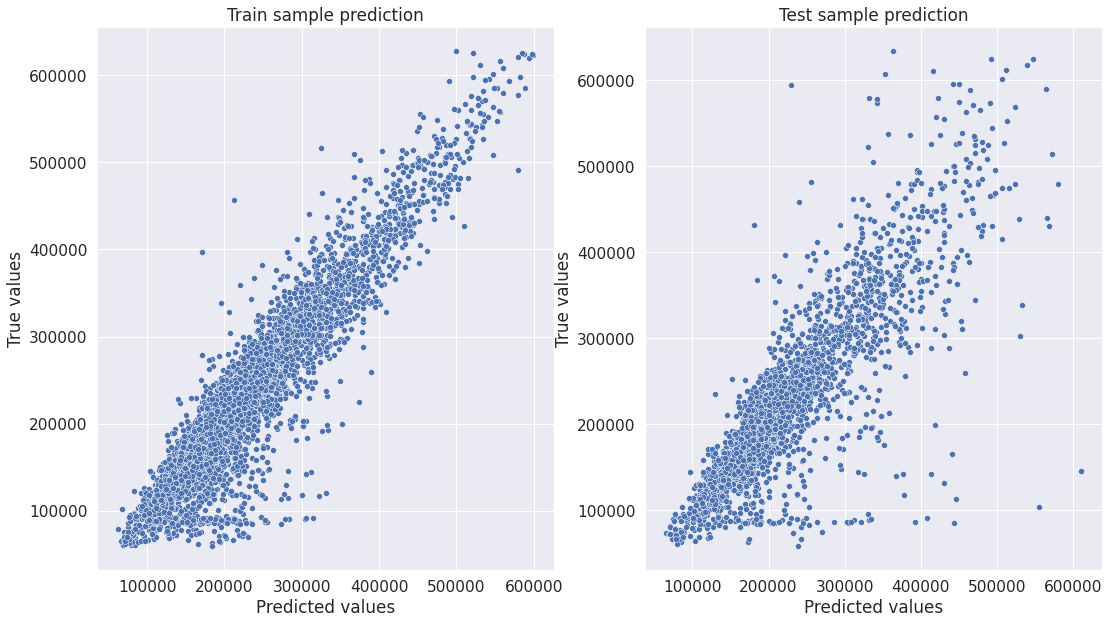

In [2843]:
from xgboost.sklearn import XGBRegressor

x_m = XGBRegressor(n_estimators=50, max_depth=5)
x_m.fit(X_train, y_train)

y_train_preds = x_m.predict(X_train)
y_valid_preds = x_m.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [2844]:
feature_importances = pd.DataFrame(zip(X_train.columns, x_m.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
28,MedPriceByHouseYearcatSquarer,0.310620
29,MedPriceBySocial,0.205842
1,Square,0.052563
27,MedPriceByHouseFloorcatSquarer,0.049390
26,MedPriceByHouseFloorcatRooms,0.038395
18,Square_change,0.037549
25,MedPriceByFloorcatSquarer,0.030132
12,Social_3,0.024290
22,DistrictSize,0.021394
0,Rooms,0.019760


In [2845]:
cv_score = cross_val_score(x_m, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.71723828, 0.69637146, 0.70056402])

#### Подбор и выбор параметров для модели

In [2846]:
params = {'n_estimators':[40, 45, 50],
          'max_depth':[3, 5]}

gs = GridSearchCV(x_m, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'max_depth': 5, 'n_estimators': 40}, 0.712146716148288)

### GradientBoostingRegressor

Train R2:	0.831
Test R2:	0.751


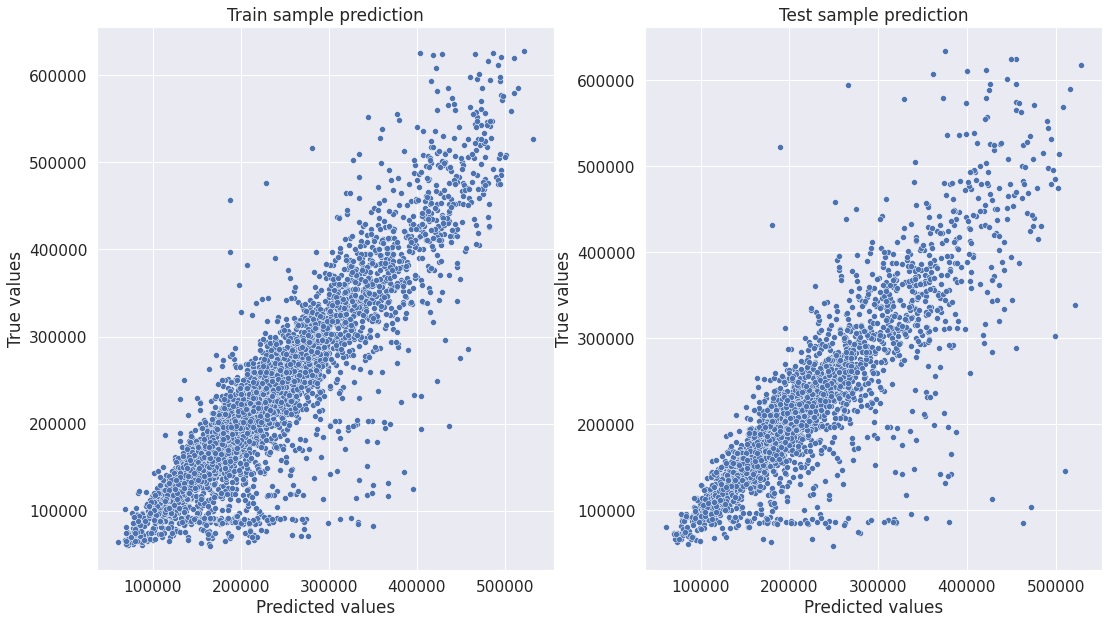

In [2847]:
gb_m = GradientBoostingRegressor(criterion='squared_error',
                                     max_depth=10,  # глубина дерева
                                     min_samples_leaf=80,  # минимальное кол-во наблюдений в листе дерева
                                     random_state=42,  
                                     n_estimators=100)  # кол-во деревьев
gb_m.fit(X_train, y_train)

y_train_preds = gb_m.predict(X_train)
y_valid_preds = gb_m.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [2848]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_m.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
28,MedPriceByHouseYearcatSquarer,0.387058
29,MedPriceBySocial,0.230834
1,Square,0.129396
22,DistrictSize,0.040695
26,MedPriceByHouseFloorcatRooms,0.021615
7,Ecology_1,0.019967
11,Social_2,0.018483
12,Social_3,0.018076
6,HouseYear,0.016994
2,LifeSquare,0.015422


In [2849]:
cv_score = cross_val_score(gb_m, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72625459, 0.70056874, 0.72135044])

#### Подбор и выбор параметров для модели

In [2850]:
params = {'max_depth': [10, 20],
          'min_samples_leaf':[80, 100],
          'n_estimators':[50, 100]
         }

gs = GridSearchCV(gb_m, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'max_depth': 10, 'min_samples_leaf': 80, 'n_estimators': 100},
 0.7209867847212246)

### Сборная модель

Train R2:	0.866
Test R2:	0.755


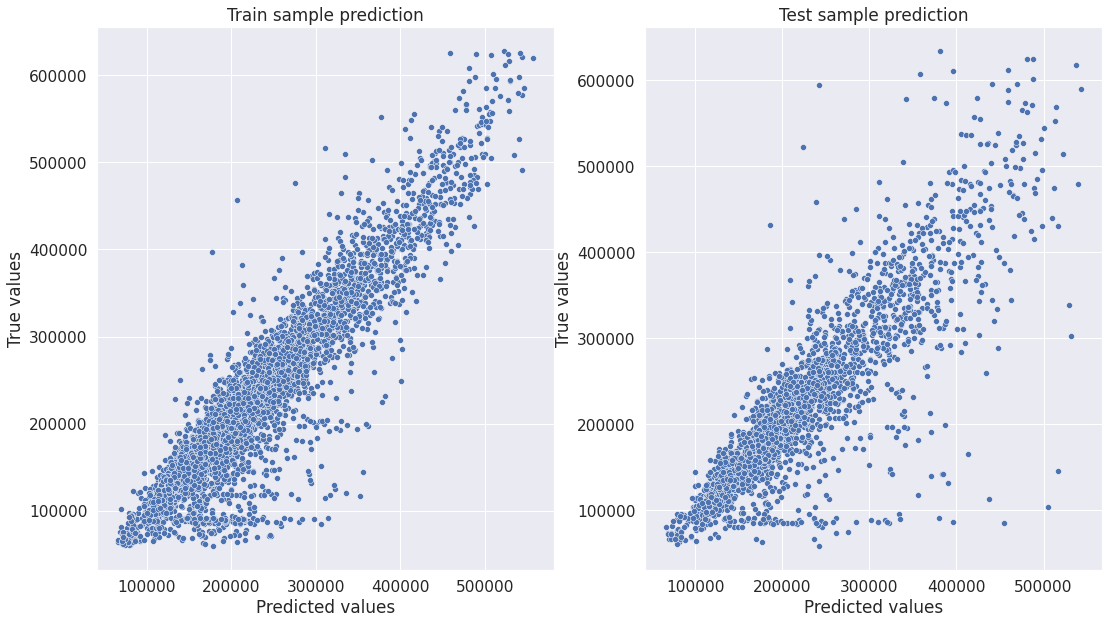

In [2851]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

stack = StackingRegressor([('gb_m', gb_m), ('l_m', l_m), ('x_m', x_m)], 
                          final_estimator=RidgeCV(),
                          n_jobs=-1)
stack.fit(X_train, y_train)

y_train_preds = stack.predict(X_train)
y_valid_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [2852]:
cv_score = cross_val_score(stack, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73072599, 0.71243158, 0.72537457])

## 9. Прогнозирование на тестовом датасете

In [2853]:
predictions = stack.predict(df_test)
predictions

array([164933.20460101, 124501.89104651, 142401.93986475, ...,
       146575.79170622, 188292.24160977, 253947.30226429])

In [2854]:
submit = pd.read_csv('sample_submission.csv')
submit

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0
...,...,...
4995,10379,200000.0
4996,16138,200000.0
4997,3912,200000.0
4998,5722,200000.0


In [2855]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,164933.204601
1,5925,124501.891047
2,960,142401.939865
3,3848,139845.102034
4,746,193513.038971


In [2856]:
submit.to_csv('stack_submit.csv', index=False)